In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import random
import os 
import imageio 
from IPython.display import Image
import pandas as pd
import csv

# Increment i by 5 starting at 1 going to 96. 

In [2]:
# Define the bounding box for the Mandelbrot set
xmin, xmax, ymin, ymax = -2.0, 1.0, -1.5, 1.5

# Fix maximum number of iterations
i_max = 100
s_values = [10, 200, 400, 600, 800, 1000]
num_runs = 5

# Create arrays to store results
num_iterations = i_max
num_samples = len(s_values)
area_estimations_sum = np.zeros((num_iterations, num_samples, num_runs))
reference_area_sum = np.zeros(num_samples)
confidence_intervals = np.zeros((num_iterations, num_samples))

# Loop for multiple runs
for run in range(num_runs):
    print(f"Run {run + 1}/{num_runs}")

    # Set the seed for each run
    np.random.seed()

    # Calculate reference area with i_max = 100 and s = 1000
    reference_s = 1000
    reference_i_max = 100
    reference_area = 0.0

    for _ in range(reference_s):
        x = np.random.uniform(xmin, xmax)
        y = np.random.uniform(ymin, ymax)
        c = complex(x, y)
        z = c

        for _ in range(reference_i_max):
            if abs(z) > 2.0:
                break
            z = z * z + c
        else:
            # Point is inside the Mandelbrot set
            reference_area += 1

    reference_area = (reference_area / reference_s) * (xmax - xmin) * (ymax - ymin)  # Scale to the full area
#     print(f"Reference Area for Run {run + 1}: {reference_area}")

    # Create a list to store the results for the current run
    results = []

    for j in range(1, i_max + 1, 5):  # Change here to iterate every 5
        for idx, s in enumerate(s_values):
            AM = 0.0
            for _ in range(s):
                x = np.random.uniform(xmin, xmax)
                y = np.random.uniform(ymin, ymax)
                c = complex(x, y)
                z = c

                for _ in range(j):
                    if abs(z) > 2.0:
                        break
                    z = z * z + c
                else:
                    # Point is inside the Mandelbrot set
                    AM += 1

            AM = (AM / s) * (xmax - xmin) * (ymax - ymin)  # Scale to the full area
            area_estimations_sum[j - 1, idx, run] = AM

            # Append results to the list
            results.append({
                'j': j,
                's': s,
                'area_estimation': AM
            })

    reference_area_sum += reference_area

    # Average the results over all runs
area_estimations_avg = np.mean(area_estimations_sum, axis=2)
reference_area_avg = reference_area_sum / num_runs


Run 1/5
Run 2/5
Run 3/5
Run 4/5
Run 5/5


In [3]:
# Save the averaged results and absolute errors to CSV files
csv_filename_avg_area = 'convergence_results_avg_area.csv'
csv_filename_avg_error = 'convergence_results_avg_error.csv'
csv_filename_subtraction = 'convergence_results_subtraction.csv'

with open(csv_filename_avg_area, 'w', newline='') as csvfile_area, open(csv_filename_avg_error, 'w', newline='') as csvfile_error, open(csv_filename_subtraction, 'w', newline='') as csvfile_subtraction:
    fieldnames_area = ['j', 's'] + [f'run_{i + 1}' for i in range(num_runs)] + ['average']
    fieldnames_error = ['j', 's', 'average_absolute_error', 'errors']  # Fix here
    fieldnames_subtraction = ['j', 's'] + [f'run_{i + 1}' for i in range(num_runs)] + ['average_subtraction', 'reference_value']

    writer_area = csv.DictWriter(csvfile_area, fieldnames=fieldnames_area)
    writer_error = csv.DictWriter(csvfile_error, fieldnames=fieldnames_error)
    writer_subtraction = csv.DictWriter(csvfile_subtraction, fieldnames=fieldnames_subtraction)

    # Write headers
    writer_area.writeheader()
    writer_error.writeheader()
    writer_subtraction.writeheader()

    # Write data
    for j in range(1, i_max + 1, 5):  # Change here to iterate every 5
        for idx, s in enumerate(s_values):
            row_data_area = {'j': j, 's': s}
            row_data_error = {'j': j, 's': s, 'errors': []}  # Fix here
            row_data_subtraction = {'j': j, 's': s, 'reference_value': reference_area_avg[idx]}

            for run in range(num_runs):
                row_data_area[f'run_{run + 1}'] = area_estimations_sum[j - 1, idx, run]
                # Fix here
                error_value = area_estimations_sum[j - 1, idx, run] - reference_area_avg[idx]
                row_data_error['errors'].append(error_value)

            row_data_area['average'] = np.mean(area_estimations_sum[j - 1, idx])

            # Fix here
            row_data_error['average_absolute_error'] = np.abs(row_data_area['average'] - reference_area_avg[idx])

            # Calculate subtraction values
            subtraction_values = [area_estimations_sum[j - 1, idx, run] - reference_area_avg[idx] for run in range(num_runs)]
            row_data_subtraction.update({f'run_{run + 1}': subtraction_values[run] for run in range(num_runs)})
            row_data_subtraction['average_subtraction'] = np.mean(subtraction_values)

            writer_area.writerow(row_data_area)
            writer_error.writerow(row_data_error)
            writer_subtraction.writerow(row_data_subtraction)


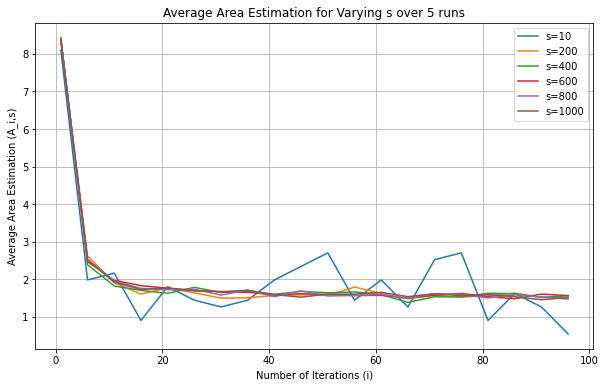

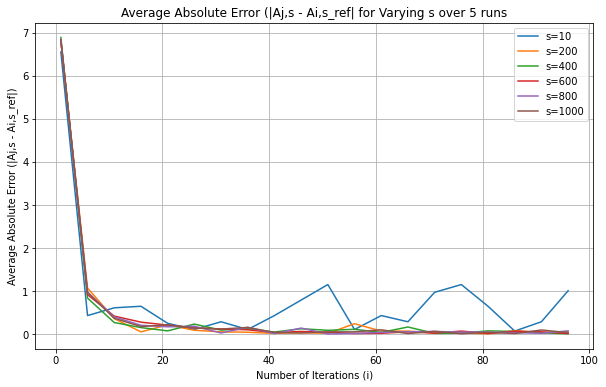

Results saved to convergence_results_avg_area.csv, convergence_results_avg_error.csv, and convergence_results_subtraction.csv


In [4]:
# Plot average area estimations for different values of s
plt.figure(figsize=(10, 6))
for idx, s in enumerate(s_values):
    plt.plot(range(1, i_max + 1, 5), area_estimations_avg[::5, idx], label=f's={s}')  # Adjust here to plot every 5

plt.xlabel('Number of Iterations (i)')
plt.ylabel('Average Area Estimation (A_i,s)')
plt.legend()
plt.title(f'Average Area Estimation for Varying s over {num_runs} runs')
plt.grid(True)
plt.show()

# Calculate absolute errors for each combination of i and s
plt.figure(figsize=(10, 6))
for idx, s in enumerate(s_values):
    # Adjust here to iterate every 5
    errors = [np.abs(area_estimations_avg[j - 1, idx] - reference_area_avg[idx]) for j in range(1, i_max + 1, 5)]
    plt.plot(range(1, i_max + 1, 5), errors, label=f's={s}')  # Adjust here to plot every 5

plt.xlabel('Number of Iterations (i)')
plt.ylabel('Average Absolute Error (|Aj,s - Ai,s_ref|)')
plt.legend()
plt.title(f'Average Absolute Error (|Aj,s - Ai,s_ref| for Varying s over {num_runs} runs')
plt.grid(True)
plt.show()

print(f'Results saved to {csv_filename_avg_area}, {csv_filename_avg_error}, and {csv_filename_subtraction}')

In [5]:
# Calculate and print confidence intervals
for j in range(1, i_max + 1, 5):
    for idx, s in enumerate(s_values):
        sample_means = area_estimations_sum[j - 1, idx, :]
        standard_deviation = np.std(sample_means, ddof=1)
        confidence_interval = 1.96 * (standard_deviation / np.sqrt(num_runs))
        confidence_intervals[j - 1, idx] = confidence_interval

# Print confidence intervals
print("Confidence Intervals:")
print("j\t\t s\t\t Confidence Interval")
for j in range(1, i_max + 1, 5):
    for idx, s in enumerate(s_values):
        print(f"{j}\t\t{s}\t\t{confidence_intervals[j - 1, idx]}")

Confidence Intervals:
j		 s		 Confidence Interval
1		10		0.7888847824619253
1		200		0.17727980595657278
1		400		0.054011248828368705
1		600		0.09856676113173267
1		800		0.06541087065618371
1		1000		0.07558487848769717
6		10		0.660028363026923
6		200		0.2876996934304934
6		400		0.1482442342892297
6		600		0.1664673589626507
6		800		0.09870915914949324
6		1000		0.19662072908012504
11		10		1.4330803745777831
11		200		0.13833629458677849
11		400		0.13405239423449317
11		600		0.1386483552012067
11		800		0.10186049945881867
11		1000		0.08236198929117726
16		10		0.7888847824619258
16		200		0.224173795078729
16		400		0.17837346103050192
16		600		0.11210617467383316
16		800		0.00986105978077396
16		1000		0.08724223986120487
21		10		1.2473363620130697
21		200		0.29831946902607603
21		400		0.10094951411472969
21		600		0.132593674057249
21		800		0.09722024789106436
21		1000		0.09922401999516055
26		10		1.4330803745777834
26		200		0.09900425445403842
26		400		0.11277879853944184
26		600		0.078888478

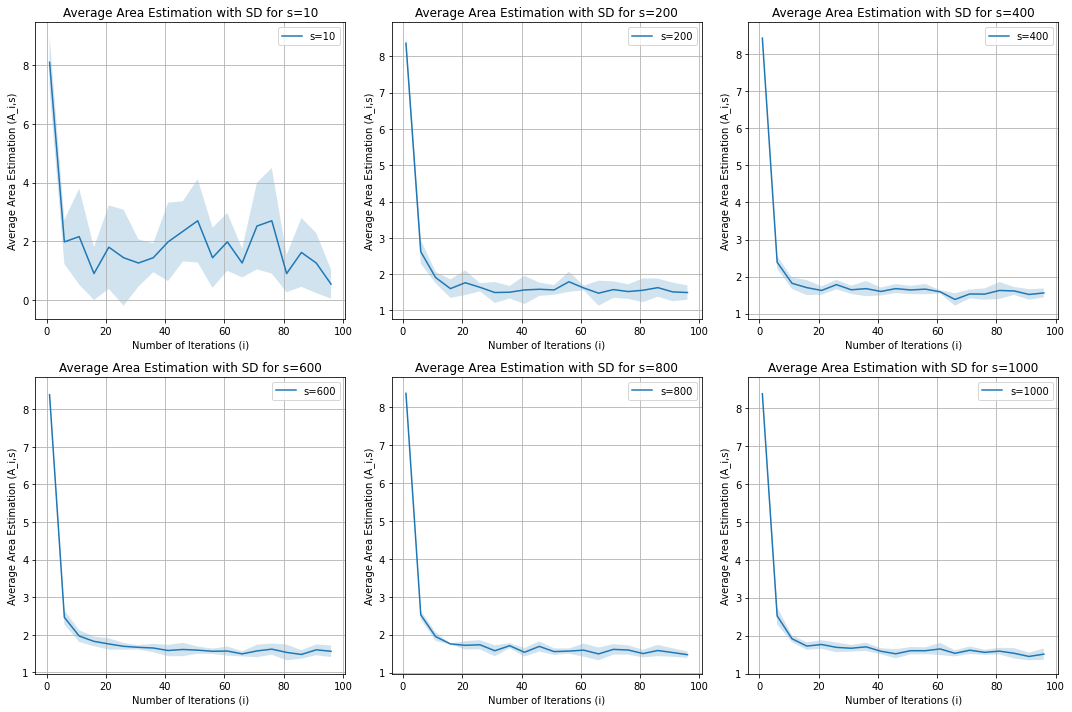

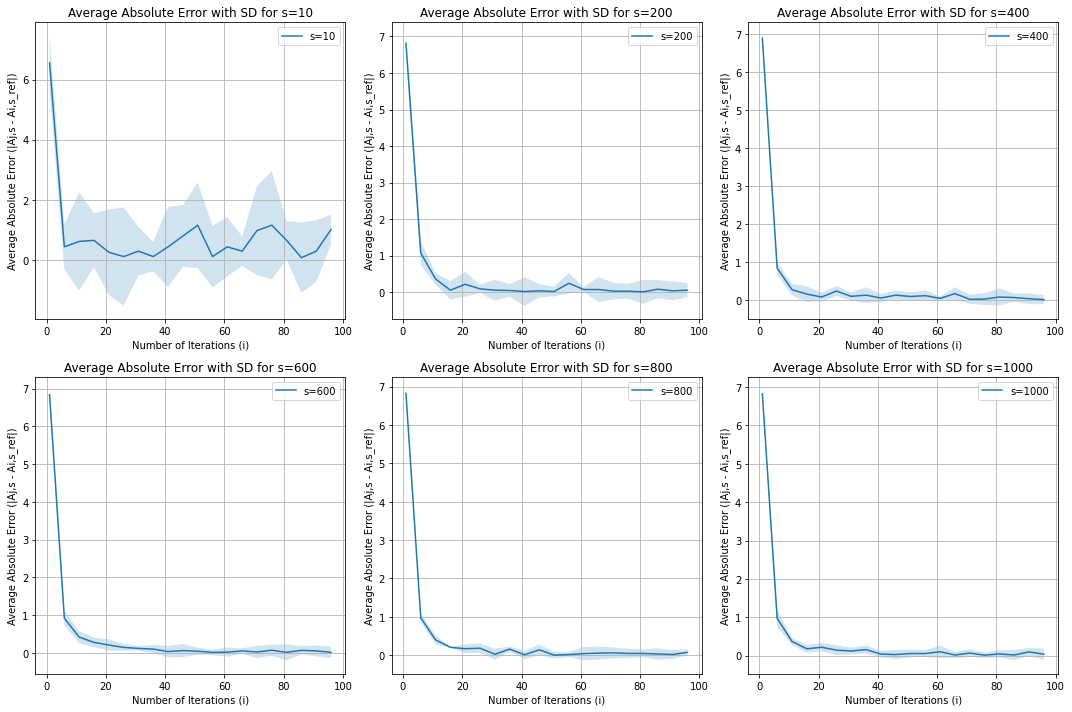

In [10]:
plt.figure(figsize=(15, 10))

for idx, s in enumerate(s_values):
    plt.subplot(2, 3, idx+1)
    avg_estimations = area_estimations_avg[::5, idx]
    std_estimations = np.std(area_estimations_sum[::5, idx, :], axis=1, ddof=1)
    plt.plot(range(1, i_max + 1, 5), avg_estimations, label=f's={s}')
    plt.fill_between(range(1, i_max + 1, 5), avg_estimations - std_estimations, avg_estimations + std_estimations, alpha=0.2)

    plt.xlabel('Number of Iterations (i)')
    plt.ylabel('Average Area Estimation (A_i,s)')
    plt.legend()
    plt.title(f'Average Area Estimation with SD for s={s}')
    plt.grid(True)

plt.tight_layout()
plt.show()

# Calculate absolute errors and standard deviation for each combination of i and s
plt.figure(figsize=(15, 10))

for idx, s in enumerate(s_values):
    plt.subplot(2, 3, idx+1)
    # Adjust here to iterate every 5
    errors = [np.abs(area_estimations_avg[j - 1, idx] - reference_area_avg[idx]) for j in range(1, i_max + 1, 5)]
    std_errors = np.std(area_estimations_sum[::5, idx, :], axis=1, ddof=1)
    plt.plot(range(1, i_max + 1, 5), errors, label=f's={s}')
    plt.fill_between(range(1, i_max + 1, 5), errors - std_errors, errors + std_errors, alpha=0.2)

    plt.xlabel('Number of Iterations (i)')
    plt.ylabel('Average Absolute Error (|Aj,s - Ai,s_ref|)')
    plt.legend()
    plt.title(f'Average Absolute Error with SD for s={s}')
    plt.grid(True)

plt.tight_layout()
plt.show()
